In [ ]:
#@title Choose seed value
Seed = 1995 #@param {type:"integer"}


!rm -rf ./logs/
%load_ext tensorboard
%matplotlib inline


import datetime
import numpy as np
from numpy.random import Generator, PCG64
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import clear_output

tf.random.set_seed(Seed)  # Seeding Tensorflow.
np.random.seed(Seed)  # Seeding Numpy.
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

'rm' is not recognized as an internal or external command,
operable program or batch file.


# MNIST Dataset - Loading & Preprocessing

In [ ]:
num_classes = 10
img_rows, img_cols, img_colors = 28, 28, 1  # Greyscale images of 28 X 28.

(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:,:,:,np.newaxis]
X_test = (X_test.astype(np.float32) - 127.5)/127.5
X_test = X_test[:,:,:, np.newaxis]

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#Classifiers For Investigation

In [ ]:
def CNN_mnist_model(img_rows, img_cols, img_colors, num_classes, learning_rate,
                    name = "CNN"):
    activation = 'relu'
    model = keras.Sequential(name=name)
    model.add(layers.Conv2D(8, kernel_size=(3, 3), input_shape=(img_rows, img_cols, img_colors), activation=activation))
    model.add(layers.Conv2D(8, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation=activation))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes))
    model.add(layers.Activation('softmax', name='softmax'))

    model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adadelta(learning_rate),
                metrics=[keras.metrics.CategoricalAccuracy()])
    return model


def train_model(model, max_epochs: int, train_images, train_labels, test_images, 
                test_labels, batch_size, callbacks_list, verbose=1):
    history = model.fit(train_images, train_labels,
        batch_size=batch_size,
        epochs=max_epochs,
        verbose=verbose,
        validation_data=(test_images, test_labels),
        callbacks=callbacks_list)
    return history

def lr_scheduler(epoch):
  return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

# Training The Classifier

In [ ]:
#@title Select The Classifier to Attack and Hyperparameters
selected_model = "CNN from Lecture 2" #@param ["CNN from Lecture 2", "NN from Ex 1"]
batch_size = 128 #@param {type:"integer"}
max_epochs = 15 #@param {type:"integer"}
learning_rate = 0.1 #@param {type:"number"}
lr_decay = 1e-6 #@param {type:"number"}
lr_drop = 6 #@param {type:"number"}

#@

classifier = CNN_mnist_model(img_rows, img_cols, img_colors, 
                             num_classes, learning_rate)
print('Architecture of Classifier:')
classifier.summary()

callbacks_list = [reduce_lr]
print("Training the Classifier:")
classifier_history = train_model(classifier, max_epochs, X_train, 
                                 y_train, X_test, y_test, 
                                 batch_size, callbacks_list)

Architecture of Classifier:
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 8)         584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               147584    
_________________________________________________________________
dropout_1 (Dropout)          (None,

# Images-Interpolation Stage

In [ ]:
# Randomly choose two images from a different class

# size:  number of images in each pair of classes (i.e. the same two classes for all paires )
# size_num: number of pairs in each class (i.e. each pair is sampled randomly)
# In total,  size*size_num images are sampled  
def sample_two_images(tf_tensor=True,size=1,size_num=1):
  source_images = np.empty((size*size_num,28,28,1))
  target_images = np.empty((size*size_num,28,28,1))
  target_label = np.empty(size*size_num)

  # Find random images indices in the test-set which correspond to these chosen classes.
  for i in range(size_num):
      # Randomly select two different classes between 0 and 9 (inclusive)
    sample = np.random.choice(10, size=2, replace=False)
    index_1 = np.where(np.argmax(y_test, axis=1) == sample[0])[0]
    index_2 = np.where(np.argmax(y_test, axis=1) == sample[1])[0]
    index_1 = np.random.choice(index_1, size=size)
    index_2 = np.random.choice(index_2, size=size)

    # Return these images as Tensors of size 1 x img_height x img_width
    source_images[i*size:(i+1)*size] = X_test[index_1]
    target_images[i*size:(i+1)*size] = X_test[index_2]
    target_label[i*size:(i+1)*size] = [sample[1]]*size




  if tf_tensor:
    source_images = tf.Variable(source_images, dtype=tf.float32)
    target_images = tf.Variable(target_images, dtype=tf.float32)


  return source_images, target_images,target_label.astype(int)


In [ ]:

def show_images(model,xStart, xEnd, mid_x=None):
    img_rows, img_cols = 28 , 28
    n_row=xStart.shape[0]

    max_steps = 11
    if mid_x is not None:
        add_step=1
    else:
        add_step=0
    total_steps=max_steps+add_step

    
    fig, ax = plt.subplots(nrows=n_row, ncols=total_steps, figsize=(15,1+n_row*1.5))

    for image in range(n_row):
        x_end=xEnd[image]
        x_start=xStart[image]

        delta = (x_end - x_start)/(max_steps - 1)

        steps = np.empty((total_steps, img_rows, img_cols, 1))
        

        for index in range(total_steps):
            if n_row>1:
                ax_i=(image,index)
            else:
                ax_i=index

            
            if mid_x is not None and index==11: # plot the Boundary image on the left side
                
                steps[index] =mid_x[image]
                pred = np.argmax(model(np.expand_dims(steps[index], 0)))

                ax[ax_i].imshow(steps[index].reshape((img_rows, img_cols)), cmap='gray')
                 # print the predict class, and  title (Boundary) in the first row
                if image==0:
                    ax[ax_i].set_title(r'$\bf Boundary  $'+   '\n  pred: {0}'.format(str(pred))  ) 
                # print the predict label 
                else:
                    ax[ax_i].set_title("pred: "+str(pred)  )

            else:
                steps[index] = x_start + index * delta   
                pred = np.argmax(model(np.expand_dims(steps[index], 0)))

                ax[ax_i].imshow(steps[index].reshape((img_rows, img_cols)), cmap='gray')
                 # print the predict class, and  title (index) in the first row
                if image==0:

                    ax[ax_i].set_title( "index: "+ str(index+1)+ "\n"+ "pred: "+str(pred)  )
                # print the predict label 
                else:
                    ax[ax_i].set_title("pred: "+str(pred)  )


            ax[ax_i].axis('off')
            
            

        
    plt.show()


"$\bf Boundary $"

# Binary-Search Stage

In [ ]:

def BoundaryBinSearch(classifier, source_images, target_images, 
                        verbose=False,
                        max_iteration = 1000 ,epsilon = 1e-7):
    LeftImage = source_images
    RightImage = target_images


    left_y = classifier(LeftImage)

    # Compute the original distance between source and destination
    dist = np.inf
    mid_x = (LeftImage + RightImage)/2
    
    iteration = 0
    while tf.greater(dist, epsilon) and iteration < max_iteration:
        if verbose and iteration % 5 == 0:
            tf.print('Bin Search Iteration: ', iteration, 'Mean dist: {0:.2f}', dist)
        
        iteration += 1
        # Calculate the mid point and the class label at that point
        left_y = classifier(LeftImage)
        right_y = classifier(RightImage)
        mid_x = (LeftImage + RightImage)/2
        mid_y = classifier(mid_x)

        sign = tf.dtypes.cast(tf.equal(tf.argmax(mid_y, axis=1), tf.argmax(right_y, axis=1)), tf.float32)

        # # Reshape the sign vector so that we can later multiply the matrix by it and preserve the original 
        # # dimensions of the input image
        sign = tf.expand_dims(tf.expand_dims(tf.expand_dims(sign, -1), -1), -1)


        # # When sign equals to 1 we want to move the right to the mid (the mid is in the target class)
        # # When sign equals to 0 we want to leave the right unchanged (the mid is in the source class)
        RightImage = sign * mid_x + (1 - sign) * RightImage
        
        # # When sign equals to 1 we want to leave the left unchanged (the mid is in the target class)
        # # When sign equals to 0 we want to move the left to the mid (the mid is in the source class)
        LeftImage = sign * LeftImage + (1 - sign) * mid_x
        
        dist = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(RightImage - LeftImage), axis=(1,2,3))))
    return mid_x,tf.argmax(mid_y, axis=1)

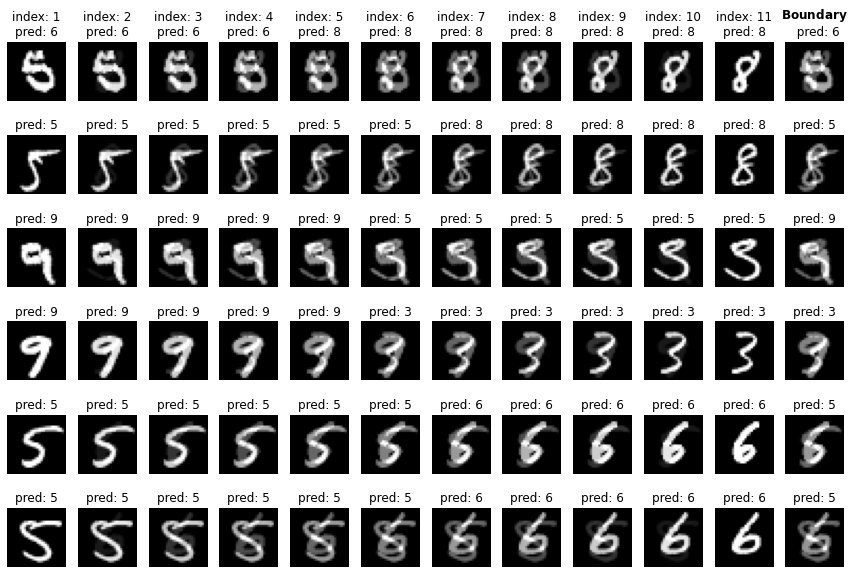

In [ ]:
source_images, target_images,target_label=sample_two_images(size=2,size_num=3)

mid_x, mid_y=BoundaryBinSearch(classifier, source_images, target_images)

show_images(classifier,source_images, target_images,mid_x)


# Example of Binary-Search Stage

#Gradient-Calculation Stage

In [ ]:
# The target tensor will be populated with a one-hot representation of the target

# S is our optimization function. It is positive if and only if the predicted class is the target one
# Since target_tensor is a one hot matrix, multiplying it with the model's output will nullify all but the
# target probability estimates. Taking a 'max' over that tensor will result with a column tensor with the probability of the 
# target class.
# Similarly, 1 - target_tensor will nullify only the target class probability estimate. Taking a max in this case will
# create a column tensor with the maximal estimate of all non-target classes.
# Together those elements provide the delta between the target class and the second highest probability.


def BoundarySlide(classifier, mid_x, target,perpendicular_step = 0.05):
    
    target_vec = np.ones(mid_x.shape[0]) * target
    target_vec = keras.utils.to_categorical(target_vec, num_classes)
    target_tensor = tf.Variable(target_vec)
    
    # Take a small step in the direction of the gradient
    mid_x_tensor = tf.Variable(mid_x)
    with tf.GradientTape() as g:
        g.watch(mid_x_tensor)
        mid_y_tensor = classifier(mid_x_tensor)

        S = tf.math.reduce_max(mid_y_tensor * target_tensor, axis=1)
        S -= tf.math.reduce_max((1 - target_tensor) * mid_y_tensor, axis=1)


    grads = g.gradient(S, mid_x_tensor)
    
    return mid_x + perpendicular_step * grads

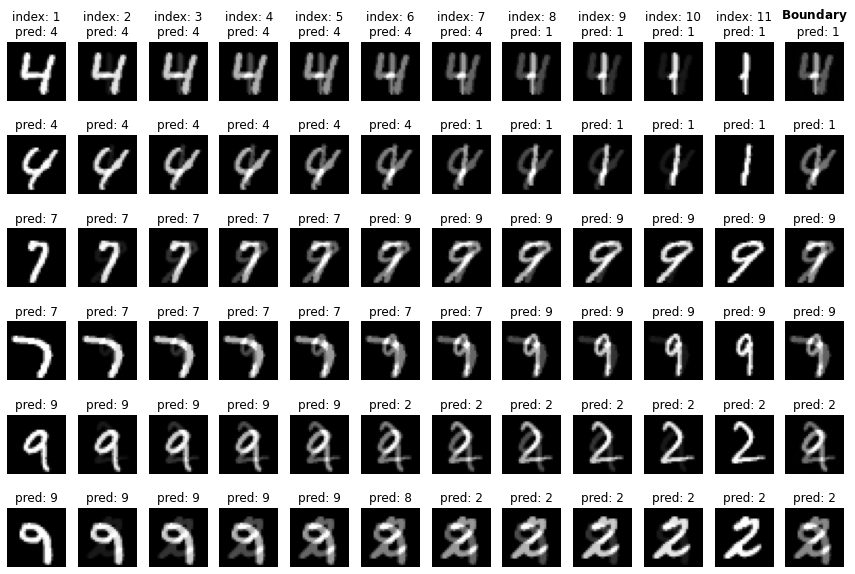

In [ ]:

source_images, target_images,target_label=sample_two_images(size=2,size_num=3)
mid_x, mid_y=BoundaryBinSearch(classifier, source_images, target_images)

midSlide=BoundarySlide(classifier, mid_x, target_label)
show_images(classifier,source_images, target_images,midSlide)


In [ ]:
def WhiteboxHopSkipJump(classifier, source_images, target_images, max_iterations = 200, target=0, collect_boundaries=False, epsilon = 1e-5):
  # Iterate -
  # 1. Find the mid points between source and dest using binary search
  # 2. Slide along the gradient
  last_dist = np.inf
  next_x = np.copy(target_images)
  boundaries = []
    
  for iteration in range(max_iterations):
    clear_output(wait=True)
    print('HopSkip Iteration: ', iteration)
    # TODO: Find current boundary point
    # next_x = None # Replace this None with something
    next_x,_=BoundaryBinSearch(classifier, source_images, next_x)

    if collect_boundaries:
      boundaries.append(next_x)
        
    # TODO: Slide along the gradient    
    next_x=BoundarySlide(classifier, next_x, target) # Replace this None with something
    
    # TODO: Clip or project the values in 'next_x' to maintain validity
    # next_x =  # Replace this None with something

    # TODO: Calculate the distance to the boundary point
    dist=tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(next_x - target_images), axis=(1,2,3))))  # Replace this None with something
        
    # Stop when the distance to the boundary can not be further reduced
    if abs(dist - last_dist) < epsilon:
      break
    else:
      last_dist = dist
  return next_x, boundaries




HopSkip Iteration:  199


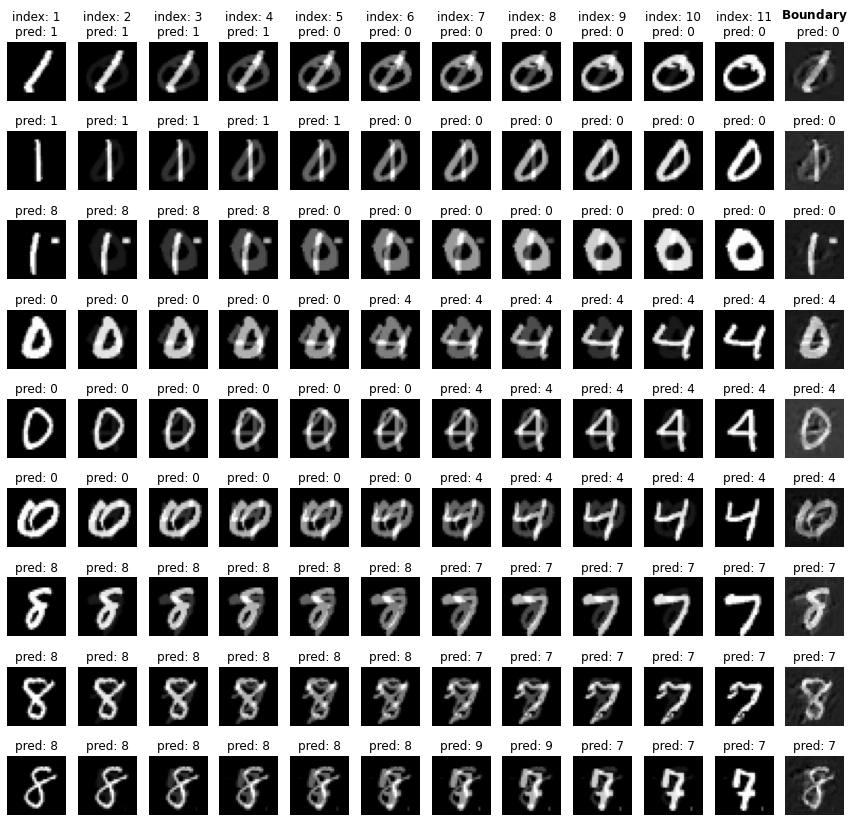

In [ ]:
source_images, target_images,target_label=sample_two_images(size=3,size_num=3)

next_x,boundaries=WhiteboxHopSkipJump(classifier, source_images, target_images, max_iterations = 200, target=target_label, collect_boundaries=False, epsilon = 1e-5)

show_images(classifier,source_images, target_images,next_x)


# Example of Gradient-Calculation Stage

In [ ]:
def PrepareAttackImages(test_images, test_labels, source_index=None, samples=100):
    # Randmly choose a source image, then choose 100 destination images of a random target class
    if source_index is None:
        source_index = np.random.randint(0,test_images.shape[0])   
    source_class = np.argmax(test_labels[source_index])
    target_class = (source_class + np.random.randint(1, num_classes-1)) % num_classes
    
    # Filter out all test images of the source class into test_images_a
    mask = np.argmax(test_labels, axis=1) == source_class
    test_images_a = test_images[mask]
    
    # Filter out all test images of the target class into test_images_b
    mask = np.argmax(test_labels, axis=1) == target_class
    test_images_b = test_images[mask]
    
    # We need image pairs for running the HopSkipJump attack. The source image is replicated for all pairs while
    # the destination image is chosen randomly from the test set
    source_x = np.repeat(np.expand_dims(test_images[source_index], axis=0),samples, axis=0)
    dest_x = test_images_b[np.random.choice(range(test_images_b.shape[0]), size=samples, replace=False)]
    
    return source_x, dest_x, source_class, target_class

In [ ]:
''' A simple utility funcion for evaluating the success of an attack
'''
import math
def TestAttack(model, adv_images, orig_images, true_label, target_label = None, boundaries = None):
    preds = model.predict(adv_images)
    score = np.sum(np.argmax(preds, axis = 1) != true_label)
    score /= adv_images.shape[0]
    print('Successfully moved out of source class: {:.2f}'.format(score))
    
    if target_label is not None:
        score = np.sum(np.argmax(preds, axis = 1) != target_label)
        score /= adv_images.shape[0]
        print('Successfully perturbed to target class: {:.2f}'.format(score))
    
    dist = np.mean(np.sqrt(np.mean(np.square(adv_images - orig_images), axis=(1,2,3))))
    print('Mean perturbation distance: {:.2f}'.format(dist))
    
    # When the intermediate boundary images are provided we plot them all
    # otherwise, choose the end result of one attack pair and plot it
    if boundaries is None:
        index = 10
        img = adv_images[index].reshape(28, 28)
        plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    else:
        cols = 8
        rows = math.ceil(len(boundaries) / cols)
        fig, ax = plt.subplots(nrows=rows, ncols = cols, figsize=(8, 1.25*rows))
        for index in range(rows*cols):
            if index < len(boundaries):
                img = boundaries[index][0].reshape(28, 28)
                ax[index // cols, index % cols].imshow(img, vmin=0, vmax=1, cmap='gray')
                ax[index // cols, index % cols].set_title(str(index))
            ax[index // cols, index % cols].axis('off')
    plt.show()

HopSkip Iteration:  99
Source index: 6743 Source class: 1 Target class: 5
Mean boundary distance: 21.75
Successfully moved out of source class: 0.95
Successfully perturbed to target class: 0.05
Mean perturbation distance: 0.25


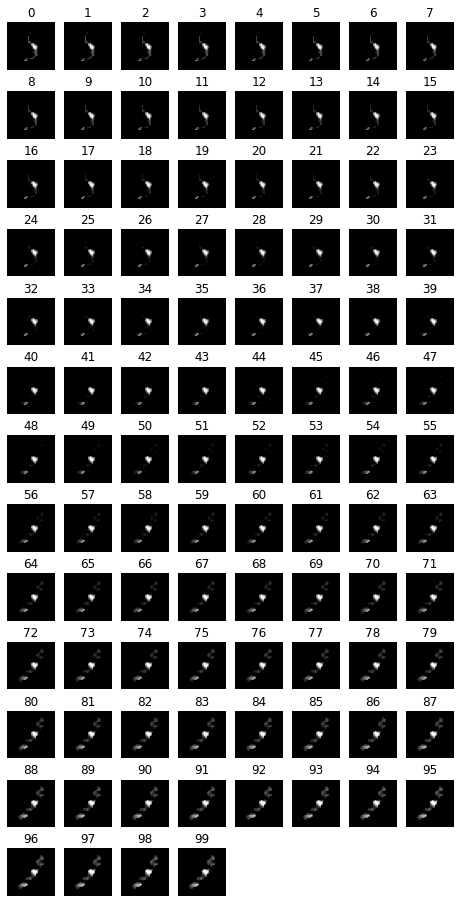

In [ ]:

samples = 100
dist = np.zeros((samples))
adv_dist = np.zeros((samples))
    
# Choose a random starting point and create image pairs for the attack
source_index = np.random.randint(0,X_test.shape[0])
source_x, dest_x, source, target = PrepareAttackImages(X_test, y_test, source_index=source_index, samples=samples)

# Calc the distance between the source and dest images
for index in range(samples):
    dist[index] = np.linalg.norm(source_x[index] - dest_x[index])

# Craft adversarial attacks against the selected source image with HopSkipJump
adv_x, boundaries = WhiteboxHopSkipJump(classifier, source_x, dest_x, target=target, max_iterations = 100, collect_boundaries=True)
print('Source index:', source_index, 'Source class:', source, 'Target class:', target)
print('Mean boundary distance:', round(np.mean(dist),2))

# Convert boundary images into numpy arrays (as opposed to tensors)
for index in range(len(boundaries)):
    boundaries[index] = boundaries[index].numpy()
TestAttack(classifier, adv_x.numpy(), source_x, source, target_label=target, boundaries=boundaries)